In [66]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../../src")

from graph_tools import create_graph_from_adj_mat
from optimization_funcs import multi_pass_optimize
from optimization_funcs import simulated_annealing
from optimization_funcs import hamiltonian_objective_function
from optimization_funcs import flip_step_function

In [11]:
""" load the graph """
curr_year = 2012
interval = 4
path = f"../../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"

adj_mat, var_list = get_sorted_adj_mat_and_var_list(path)
G = create_graph_from_adj_mat(adj_mat, var_list)

In [39]:
def get_frust_mat(adj_mat, vectors):
    return vectors[:, :, None] * (vectors[:, None, :] * adj_mat[None,:,:])

def get_frust_percentage(frust_mat):
    num_measurements = frust_mat.shape[0]
    frust_percentage = np.sum(np.sign(frust_mat) == -1, axis=0) / num_measurements
    return frust_percentage

In [57]:
""" find energy minima, and find how often each edge is frustrated"""

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, 102))
mp_minima, num_changed = multi_pass_optimize(initial_vectors, adj_mat, max_iterations=int(1e4))
frust_mat = get_frust_mat(adj_mat, mp_minima)
frust_percentage = get_frust_percentage(frust_mat)

(array([208.,  62.,  22.,  42.,  16.,   0.,  24.,  12.,  38.,  24.,  28.,
          8.,  46.,  46.,  16.,  42.,  50.,  18.,  12.,  12.]),
 array([0.    , 0.0268, 0.0536, 0.0804, 0.1072, 0.134 , 0.1608, 0.1876,
        0.2144, 0.2412, 0.268 , 0.2948, 0.3216, 0.3484, 0.3752, 0.402 ,
        0.4288, 0.4556, 0.4824, 0.5092, 0.536 ]),
 <BarContainer object of 20 artists>)

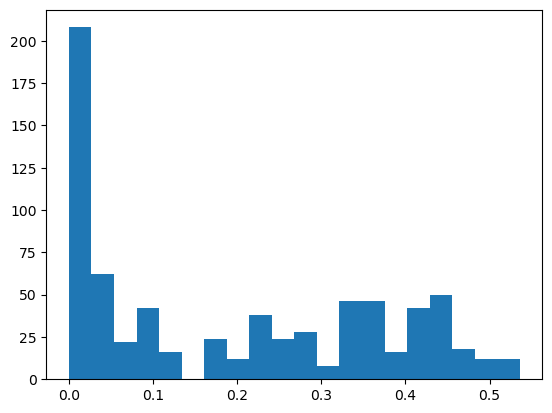

In [45]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage[adj_mat != 0], bins=20)


In [ ]:
""" Find energy minima using simulated annealing, and see how often each edge is frustrated """

initial_vectors = np.random.choice([-1, 0, 1], size=(1000, 102))
sa_minima, costs = simulated_annealing(initial_vectors, 100, 0.99, int(1e5), 
                              lambda vecs: hamiltonian_objective_function(vecs, adj_mat),
                              lambda vecs: flip_step_function(vecs, num_flips=1))


c:\Users\vicvi\BeliefNetworkEvo\MESSY\nbk\analyses\../../src\optimization_funcs.py:71: RuntimeWarning: overflow encountered in exp
  acceptance_prob_vector = np.where(new_cost_vector < old_cost_vector, 1, np.exp((old_cost_vector - new_cost_vector) / temperature))


In [62]:
""" calculate the frustration for the simulated annealing minima"""

frust_mat_sa = get_frust_mat(adj_mat, sa_minima)
frust_percentage_sa = get_frust_percentage(frust_mat_sa)

(array([264.,  28.,  52.,  18.,  22.,  46.,  10.,  16.,  10.,  26.,  44.,
         18.,  58.,  20.,  32.,  38.,  14.,   6.,   0.,   4.]),
 array([0.     , 0.02865, 0.0573 , 0.08595, 0.1146 , 0.14325, 0.1719 ,
        0.20055, 0.2292 , 0.25785, 0.2865 , 0.31515, 0.3438 , 0.37245,
        0.4011 , 0.42975, 0.4584 , 0.48705, 0.5157 , 0.54435, 0.573  ]),
 <BarContainer object of 20 artists>)

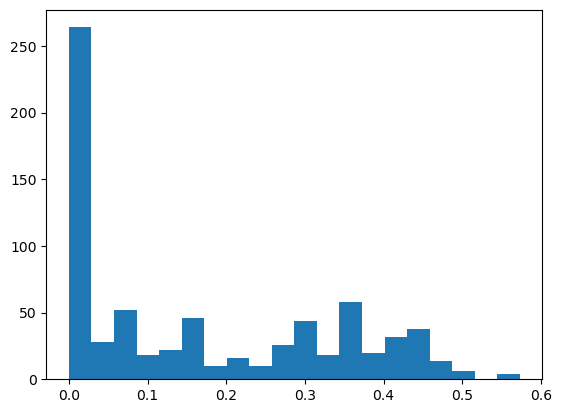

In [63]:
""" make a histogram of the frustrations """

plt.hist(frust_percentage_sa[adj_mat != 0], bins=20)

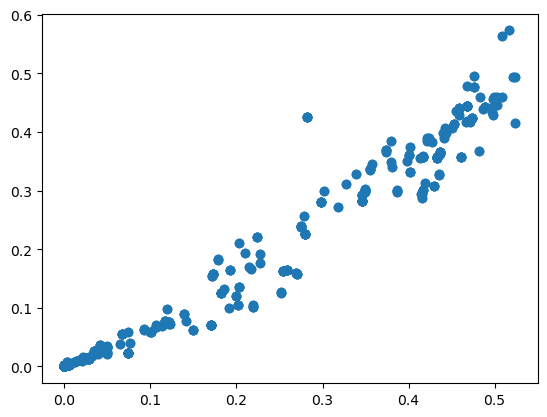

In [64]:
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_sa[adj_mat != 0])

In [81]:
""" get a set of vector assignments by doing breadth first search on the graph"""

bfs_vectors = np.zeros((1000, 102))
for i in range(1000):
    assignments = assign_nodes_search(G, breadth_first=True)
    
    for j, node in enumerate(var_list):
        bfs_vectors[i, j] = assignments[node][0]  

(array([488., 166.,  20.,  10.,  10.,   8.,   0.,   2.,   0.,   4.,   0.,
          0.,   0.,   0.,   2.,   2.,   8.,   0.,   4.,   2.]),
 array([0.     , 0.03225, 0.0645 , 0.09675, 0.129  , 0.16125, 0.1935 ,
        0.22575, 0.258  , 0.29025, 0.3225 , 0.35475, 0.387  , 0.41925,
        0.4515 , 0.48375, 0.516  , 0.54825, 0.5805 , 0.61275, 0.645  ]),
 <BarContainer object of 20 artists>)

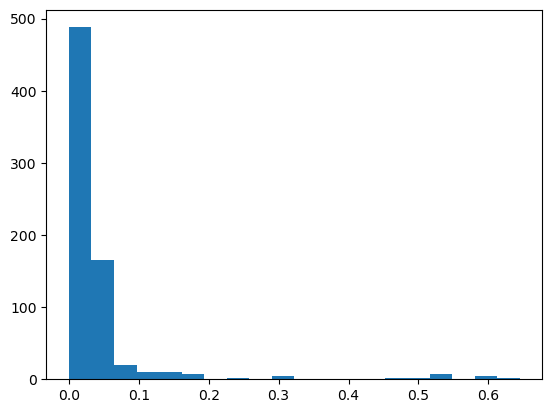

In [82]:
frust_mat_bfs = get_frust_mat(adj_mat, bfs_vectors)
frust_percentage_bfs = get_frust_percentage(frust_mat_bfs)

""" make a histogram of the frustrations """
plt.hist(frust_percentage_bfs[adj_mat != 0], bins=20)

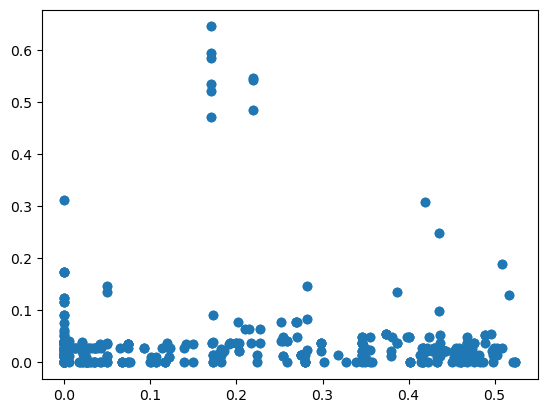

In [83]:
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_bfs[adj_mat != 0])

In [78]:
""" get a set of vector assignments by doing a random walk first search on the graph"""

rw_vectors = np.zeros((1000, 102))
for i in range(100):
    assignments = assign_nodes_random_walk(G, weighted=True, iterations_per_node=100)
    
    for j, node in enumerate(var_list):
        rw_vectors[i, j] = assignments[node] 

(array([576.,  72.,  28.,  24.,   6.,   4.,   4.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   4.]),
 array([0.     , 0.00375, 0.0075 , 0.01125, 0.015  , 0.01875, 0.0225 ,
        0.02625, 0.03   , 0.03375, 0.0375 , 0.04125, 0.045  , 0.04875,
        0.0525 , 0.05625, 0.06   , 0.06375, 0.0675 , 0.07125, 0.075  ]),
 <BarContainer object of 20 artists>)

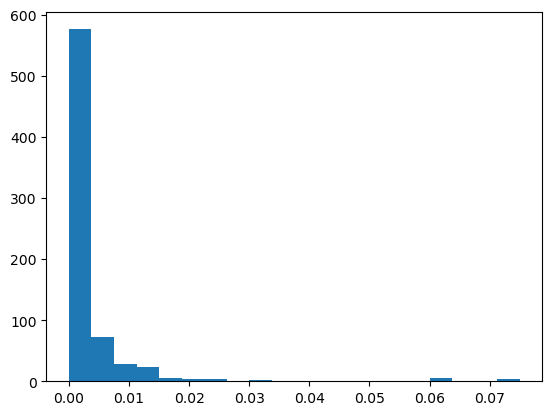

In [84]:
frust_mat_rw = get_frust_mat(adj_mat, rw_vectors)
frust_percentage_rw = get_frust_percentage(frust_mat_rw)

""" make a histogram of the frustrations """
plt.hist(frust_percentage_rw[adj_mat != 0], bins=20)

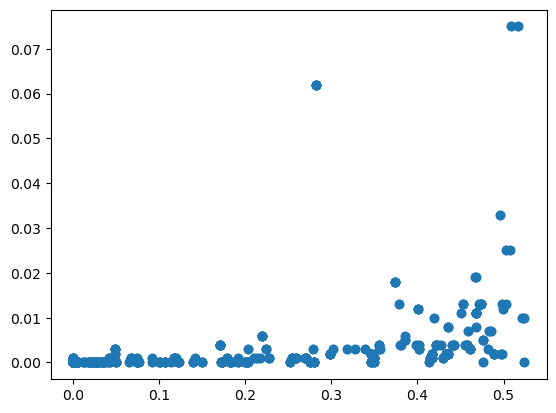

In [85]:
plt.scatter(frust_percentage[adj_mat != 0], frust_percentage_rw[adj_mat != 0])

In [28]:
test_adj_mat = np.array([[1, 2, 3],
                         [4, 5, 6],
                         [7, 8, 9]])

test_vectors = np.array([[-1,  1, -1],
                         [ 1, -1,  1],
                         [-1, -1,  1],
                         [ 1, -1, -1],
                         [-1, -1, -1]])

expected_quad_form = np.array([[[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1, -2, 3],[-4, 5, -6],[7, -8, 9]],
                               [[1,  2, -3],[4, 5, -6],[-7, -8, 9]],
                               [[1, -2, -3],[-4, 5, 6],[-7, 8, 9]],
                               [[1, 2, 3],[4, 5, 6], [7, 8, 9]]])

np.testing.assert_array_equal(expected_quad_form, get_frust_mat(test_adj_mat, test_vectors))

In [77]:
""" 
various functions 
TODO split into src files and put into the new CLEAN repo
"""
def find_consistent_clusters_greedy(G):
    connected_components = list(nx.connected_components(G))

    for component in connected_components:
        consistent_sets = component.copy()


def calculate_interaction_strength(G, set_1, set_2):
    total_strength = 0
    for node in set_1:
        for u, v, d in G.edges(node, data=True):
            if v in set_2:
                total_strength += np.abs(d["weight"])
    
    return total_strength


def merge_sorted_lists(list1, list2):

    def safe_index(lst, i):
        if (i >= 0 and i < len(lst)) or (i < 0 and i >= -len(lst)):
            return lst[i].lower()
        else:
            return chr(1114111)
    
    # Initialize pointers for both lists
    i, j = 0, 0
    merged_list = []
    list1_inds = []
    list2_inds = []
    
    curr_ind = -1
    # Traverse both lists and insert smaller value from either list into the merged list
    while i < len(list1) or j < len(list2):

        # print(merged_list)
        # print("1", safe_index(list1, i), i)
        # print("2", safe_index(list2, j), j)
        
        # never repeat an entry
        # you're only ever at risk of doing this if the last entry is the same as your current one
        if safe_index(list1, i) == safe_index(merged_list, -1):
            # print("1 repeat")
            list1_inds.append(curr_ind)
            i += 1
        elif safe_index(list2, j) == safe_index(merged_list, -1):
            # print("2 repeat")
            list2_inds.append(curr_ind)
            j += 1
        elif safe_index(list1, i) < safe_index(list2, j):
            # print("1 add")
            curr_ind += 1
            list1_inds.append(curr_ind)
            merged_list.append(list1[i])
            i += 1
        else:
            curr_ind += 1
            list2_inds.append(curr_ind)
            merged_list.append(list2[j])
            # print("2 add")
            j += 1

    return merged_list, list1_inds, list2_inds

def combine_variable_matrix_stacks(var_list_1, var_list_2, var_mat_1, var_mat_2):
    var_list, l1_indices, l2_indices = merge_sorted_lists(var_list_1, var_list_2)
    
    def make_super_matrix_stack(old_mat, submat_indices, new_size):
        new_matrix_stack = np.full((old_mat.shape[0], new_size, new_size), np.nan)
        dim1 = np.ix_(submat_indices, submat_indices)[0]
        dim2 = np.ix_(submat_indices, submat_indices)[1]
        new_matrix_stack[:, dim1, dim2] = old_mat

        return new_matrix_stack

    new_var_mat_1 = make_super_matrix_stack(var_mat_1, l1_indices, len(var_list))
    new_var_mat_2 = make_super_matrix_stack(var_mat_2, l2_indices, len(var_list))

    new_var_mat = np.concatenate((new_var_mat_1, new_var_mat_2), axis=0)

    return var_list, new_var_mat

def csv_to_sorted_list(path):
    # Initialize an empty list to store the strings
    lines = []

    # Open the CSV file and read it
    with open(path, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Join the row into a single string separated by commas
            line = ','.join(row)
            lines.append(line)
    
    indexed_list = list(enumerate(lines))
    sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1]) # sort based on the value
    index_list = [ind for ind, val in sorted_indexed_list]
    value_list = [val for ind, val in sorted_indexed_list]

    return index_list, value_list

def make_edge_time_series_from_graph(start_year, end_year, interval, overlap, node1, node2):
    curr_year = start_year
    edge_weights = []
    years = []
    while curr_year + interval <= end_year:
        path = f"../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"
        G = nx.read_graphml(os.path.join(path, "graph_object.graphml"))
        _, var_list = csv_to_sorted_list(os.path.join(path, "variables_list.csv"))
        
        if node1 in G and node2 in G:
            edge_data = G.get_edge_data(node1, node2)

            if edge_data is None:
                edge_val = 0
            else:
                edge_val = edge_data.get('weight')
        else:
            edge_val = None

        years.append(curr_year)
        edge_weights.append(edge_val)
        curr_year = curr_year + interval - overlap
  

    return edge_weights, years

def get_sorted_adj_mat_and_var_list(path):
    ind_list, var_list = csv_to_sorted_list(os.path.join(path, "variables_list.csv"))
    l = len(var_list)
    adj_mat = np.genfromtxt(os.path.join(path, "correlation_matrix_partial.csv"), delimiter=',')
    adj_mat = adj_mat[ind_list, :][:, ind_list] - np.identity(l)
    
    return adj_mat, var_list

def make_edge_time_series(start_year, end_year, interval, overlap):
    curr_year = start_year
    years = []
    while curr_year + interval <= end_year:
        path = f"../out/belief networks/{curr_year}-{curr_year + interval}, R=0.2, Condition=None"
        print(path)

        new_data, new_var_list = get_sorted_adj_mat_and_var_list(path)
        new_data = new_data.reshape(1, len(new_var_list), len(new_var_list))

        if start_year != curr_year:
            curr_var_list, curr_data = combine_variable_matrix_stacks(curr_var_list, new_var_list, curr_data, new_data)
        else:
            curr_var_list = new_var_list
            curr_data = new_data

        years.append(curr_year)
        curr_year = curr_year + interval - overlap
  

    return curr_var_list, curr_data, years

def merge_graphs_with_weight_diff(before_graph, after_graph, pct_change=False):
    # Create a new empty graph
    merged_graph = nx.Graph()

    # Add nodes from both graphs to the new graph
    merged_graph.add_nodes_from(before_graph.nodes())
    merged_graph.add_nodes_from(after_graph.nodes())

    # Get the union of edges from both graphs
    all_edges = set(before_graph.edges()).union(set(after_graph.edges()))

    # Add edges with the sum of weights
    for edge in all_edges:
        # Get the weight of the edge in graph1 (0 if the edge doesn't exist)
        
        before_weight = before_graph[edge[0]].get(edge[1], {}).get('weight', 0) if edge[0] in before_graph and edge[1] in before_graph else 0
        
        # Get the weight of the edge in graph2 (0 if the edge doesn't exist)
        after_weight = after_graph[edge[0]].get(edge[1], {}).get('weight', 0) if edge[0] in after_graph and edge[1] in after_graph else 0
        
        # Add the edge with the summed weight to the new graph
        change = (after_weight - before_weight)/((before_weight + after_weight)/2) if pct_change else after_weight - before_weight
        merged_graph.add_edge(edge[0], edge[1], weight=after_weight, type=change)

    return merged_graph

def make_change_graph(adj_var_list, adj_mat, change_var_list, change_mat):
    new_change_mat = make_consistent_matrix(adj_var_list, change_var_list, change_mat)
    num_nodes = adj_mat.shape[0]

    G = nx.Graph()
    G.add_nodes_from(adj_var_list)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_mat[i, j] != 0 or ~np.isnan(new_change_mat[i, j]):
                weight = max(1e-5, adj_mat[i, j])
                change = 0 if np.isnan(new_change_mat[i, j]) else new_change_mat[i, j]

                G.add_edge(adj_var_list[i], adj_var_list[j], weight=weight, type=change)
    
    return G

def calc_sd_change_from_window_mean(matrix_stack, window, start_at=None, reqd_samples=None):
    start_row = window if start_at is None else start_at
    reqd_samples = window if reqd_samples is None else reqd_samples
    change_mat = np.full(matrix_stack.shape, np.nan)
    
    for curr_row in range(start_row, matrix_stack.shape[0]):
        window_start = max(0, curr_row - window)
        relevant_substack = matrix_stack[window_start:curr_row, :, :]
        sufficient_samples = np.sum(~np.isnan(relevant_substack), axis=0) >= reqd_samples

        window_mean = np.where(sufficient_samples, np.nanmean(relevant_substack, axis=0), np.nan)
        window_sdev = np.where(sufficient_samples, np.nanstd(relevant_substack, axis=0), np.nan)
        denominator = np.where(window_sdev != 0, window_sdev, np.nan)
        change_mat[curr_row, :, :] = (matrix_stack[curr_row, :, :] - window_mean) / denominator

    return change_mat

def assign_nodes_search(G, breadth_first=True):
    connected_components = list(nx.connected_components(G))

    start_sign = 1
    nodes_assigned = {}

    for component in connected_components:
        start_node = np.random.choice(list(component))    
        nodes_to_visit = [(start_node, start_sign, None)]

        while len(nodes_to_visit) > 0:
            pop_ind = 0 if breadth_first else -1
            curr_node, curr_val, parent = nodes_to_visit.pop(pop_ind)
            
            if curr_node not in nodes_assigned:
                nodes_assigned[curr_node] =  (curr_val, parent)

                for node, other_node, dat in G.edges(curr_node, data=True):
                    if other_node not in nodes_assigned:
                        nodes_to_visit.append((other_node, np.sign(dat["weight"]) * curr_val, curr_node))
    
    return nodes_assigned

def assign_nodes_random_walk(G, weighted=True, iterations_per_node=100):
    connected_components = list(nx.connected_components(G))

    start_sign = 1
    nodes_assigned = {node: 0 for node in G.nodes()}

    for component in connected_components:
        component_size = len(component)
        curr_node = np.random.choice(list(component))  
        curr_val = start_sign
        curr_edges = G.edges(curr_node, data=True)
        counter = 0

        while (len(component) > 0 or counter < iterations_per_node * component_size) and len(curr_edges) > 0:
            nodes_assigned[curr_node] += curr_val

            if curr_node in component:
                component.remove(curr_node)
            
            neighbor_list = [v for u, v, d in curr_edges]
            weight_arr = np.array([d['weight'] for u, v, d in curr_edges])
            prob_arr = np.abs(weight_arr) / np.abs(weight_arr).sum() if weighted else np.ones((len(neighbor_list))) / len(neighbor_list)

            curr_node_ind = np.random.choice(range(len(neighbor_list)), p=prob_arr)
            
            curr_val = np.sign(weight_arr[curr_node_ind]) * np.sign(nodes_assigned[curr_node])
            curr_node = neighbor_list[curr_node_ind]
            curr_edges = G.edges(curr_node, data=True)
            
            counter += 1
    
    for node in nodes_assigned:
        val = np.sign(nodes_assigned[node])
        nodes_assigned[node] = val

    return nodes_assigned